In [79]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [1]:
!pip3 install emnist

In [5]:
from emnist import list_datasets

In [6]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [7]:
from emnist import extract_training_samples

In [18]:
X_train, y_train, = extract_training_samples('letters')

In [64]:
X_train = X_train.reshape(-1, 28*28)

In [65]:
X_train = X_train.astype('float32') / 255

In [72]:
X_train.shape

(124800, 784)

IndexError: index 26 is out of bounds for axis 1 with size 26

In [21]:
from emnist import extract_test_samples

In [22]:
X_test,y_test = extract_test_samples('letters')

In [19]:
X_train.shape

(124800, 28, 28)

In [23]:
y_test.shape

(20800,)

In [24]:
X_test.shape

(20800, 28, 28)

In [80]:
!pip3 install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=bd2493748c62451255428d9fd850030dec2f0febb2d4b3ab82fde0f1f89aa227
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [81]:

from imutils import paths

### Todo

create subset of clients

- increase comm rounds 300
- increase hidden units 400
- increase no of layers
- no of clients 20

In [82]:
debug = 1

In [83]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels        
        im_gray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten() # cv2.imread(imgpath) 
        # print(image.shape)
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    
    return data, labels

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss


In [84]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    
#     def build(shape, classes):
#         model = Sequential()
#         model.add(Input(shape=(shape[0], shape[1], shape[2])))
#         #model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Flatten())
#         model.add(Dense(32))
#         model.add(Dense(classes))
#         model.add(Activation("softmax"))
#         return model

In [85]:
#declear path to your mnist data folder
img_path = '../input/mnistasjpg/trainingSet/trainingSet' #'../input/cifar10-pngs-in-folders/cifar10/test'  # <-- test dataset #'../input/mnistasjpg/trainingSample/trainingSample' # <-- smaller dataset

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


In [88]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

### IID

In [94]:
len(X_train), len(X_test), len(y_train), len(y_test)
X_train[0].shape

(784,)

In [95]:
#create clients
clients = create_clients(X_train,y_train, num_clients=100, initial='client')

In [ ]:
# client_names = ['{}_{}'.format('client', i+1) for i in range(100)]
# s = clients['client_1'][0][1]*0
# for c in client_names:
#     sum = clients[c][0][1]
#     for i in range(1,378):
#         sum = sum + clients[c][i][1]
        
#     s = s + sum/378
# s

In [96]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [97]:
lr = 0.01
comms_round = 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [101]:
#initialize global model

build_shape = 784 #(28, 28, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

In [102]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    # print(client_names, len(client_names))
    random.shuffle(client_names)
    
#     if debug: 
#         # print('all_client_names', all_client_names)
#         print('client_names', client_names, len(client_names))
                
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        # print('scaling_factor', scaling_factor)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

comm_round: 0 | global_acc: 49.167% | global_loss: 2.2711257934570312
comm_round: 1 | global_acc: 63.048% | global_loss: 2.220810651779175
comm_round: 2 | global_acc: 70.548% | global_loss: 2.139596700668335
comm_round: 3 | global_acc: 73.762% | global_loss: 2.0412774085998535
comm_round: 4 | global_acc: 78.143% | global_loss: 1.9577683210372925
comm_round: 5 | global_acc: 80.024% | global_loss: 1.8933486938476562
comm_round: 6 | global_acc: 81.738% | global_loss: 1.8503377437591553
comm_round: 7 | global_acc: 83.119% | global_loss: 1.814127802848816
comm_round: 8 | global_acc: 83.167% | global_loss: 1.7870755195617676
comm_round: 9 | global_acc: 84.476% | global_loss: 1.7650591135025024
comm_round: 10 | global_acc: 84.381% | global_loss: 1.7501126527786255
comm_round: 11 | global_acc: 85.595% | global_loss: 1.7347944974899292
comm_round: 12 | global_acc: 85.881% | global_loss: 1.7215055227279663
comm_round: 13 | global_acc: 86.524% | global_loss: 1.7103245258331299
comm_round: 14 | gl

IID | total comm rounds 300


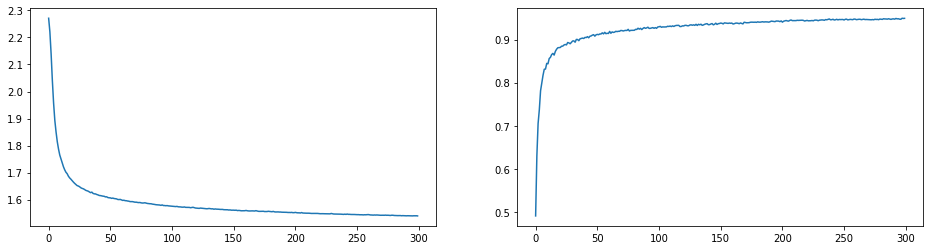

In [104]:
# IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('IID | total comm rounds', len(global_acc_list))

In [105]:
iid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
iid_df.to_csv('MNIST_IID.csv',index=False)

### Non-IID

In [49]:
import itertools

In [106]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    # data = list(zip(image_list, label_list))
    # random.shuffle(data)  # <- IID
    
    # sort data for non-iid
    max_y = np.argmax(label_list, axis=-1)
    print(max_y)
    sorted_zip = sorted(zip(max_y,label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [107]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [108]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

[3 3 4 ... 6 7 8]


In [109]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [63]:
test_batched

<BatchDataset shapes: ((None, 28, 28), (None,)), types: (tf.uint8, tf.uint8)>

In [110]:
lr = 0.01 
comms_round = 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [111]:
#initialize global model

build_shape = 784 #(32, 32, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

In [112]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


In [114]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    random.shuffle(client_names)
    if debug: 
        # print('all_client_names', all_client_names)
        print('client_names', client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        print()
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

client_names ['client_72', 'client_54', 'client_36', 'client_1', 'client_66', 'client_47', 'client_14', 'client_97', 'client_8', 'client_63']










comm_round: 0 | global_acc: 20.405% | global_loss: 2.2711212635040283
client_names ['client_52', 'client_100', 'client_13', 'client_63', 'client_41', 'client_77', 'client_1', 'client_15', 'client_91', 'client_56']










comm_round: 1 | global_acc: 25.476% | global_loss: 2.2535452842712402
client_names ['client_45', 'client_91', 'client_44', 'client_5', 'client_82', 'client_72', 'client_88', 'client_76', 'client_33', 'client_38']










comm_round: 2 | global_acc: 28.405% | global_loss: 2.2463927268981934
client_names ['client_90', 'client_66', 'client_49', 'client_50', 'client_5', 'client_43', 'client_22', 'client_15', 'client_3', 'client_84']










comm_round: 3 | global_acc: 27.619% | global_loss: 2.217033624649048
client_names ['client_14', 'client_51', 'client_72', 'client_13', 'client_34', 'client_23', 'client_30', 'clie

Non-IID | total comm rounds 300


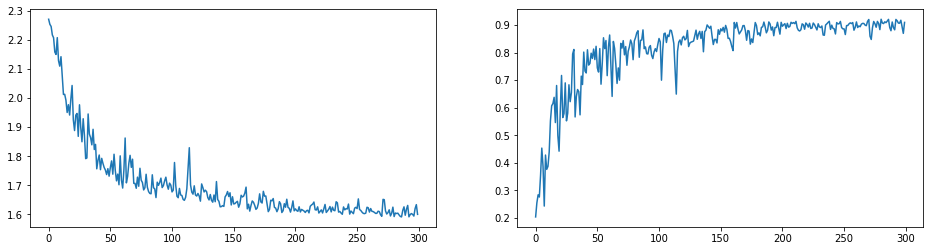

In [115]:
# Non-IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))           

In [117]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
noniid_df.to_csv('Final_mnist_output.csv',index=False)